* [Purpose] The proposed MW-GA-GRU model is compared with ARIMA, GARCH, ANN, SVR, RNN, LSTM, and GRU based on the data of copper price in Changjiang.

### Import related package.

In [2]:
## Data preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## Visulization
import matplotlib.pyplot as plt

## ARIMA and SARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ndiffs
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm ##Automatically decide on ARIMA configuration
import statsmodels.api as sm

## The warning infomation dialog
import warnings
warnings.filterwarnings("ignore")

#### Read performance indicator data

In [3]:
performance = pd.read_csv("result_data.csv")
performance.columns = ["Actual", "MW-GA-GRU"]

#### Create function "read()" to read the training data

In [4]:
def read(path):
    return pd.read_csv(path)

In [5]:
path = "WeeklyFinalData.csv"
data = read(path)
train = data["CCSP"][:-92]
test = data["CCSP"][-92:]
data = data["CCSP"]

### Build the mention above model like ARIMA, GARCH, ANN, SVR, RNN, LSTM, and GRU.

# 1. Modeling for ARIMA

Visualize the data to decide the hyperparameter of the ARIMA model (p,d,q)

### Determine hyperparameters using ACF, PACF

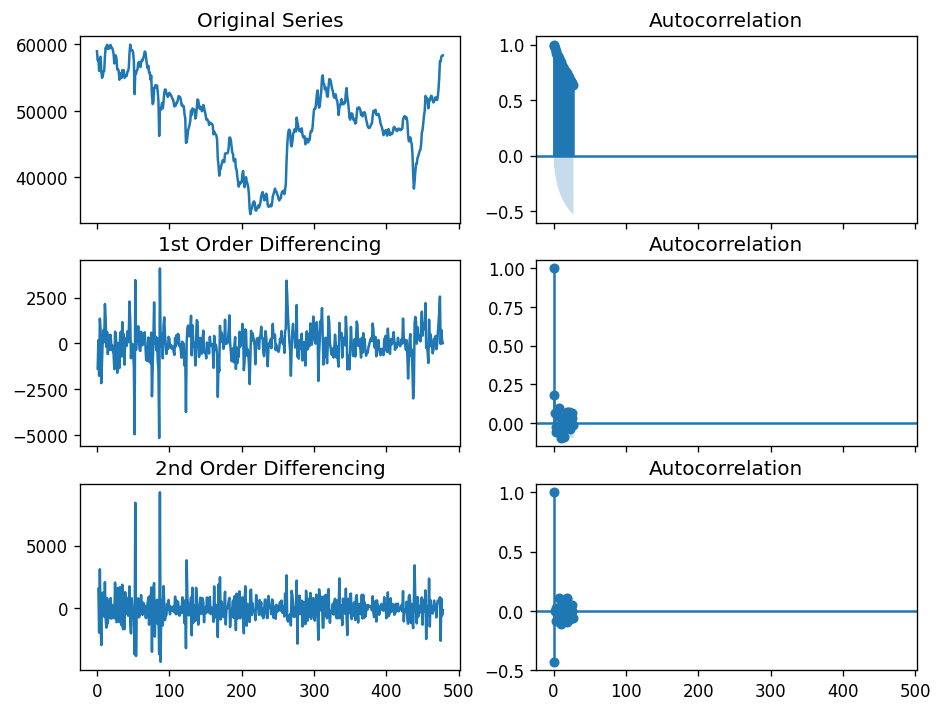

In [7]:
# Original Series
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


fig, axes = plt.subplots(3, 2, sharex=True)
axes[0,0].plot(data)
axes[0, 0].set_title('Original Series')
plot_acf(data, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.diff()); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.diff().diff()); 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

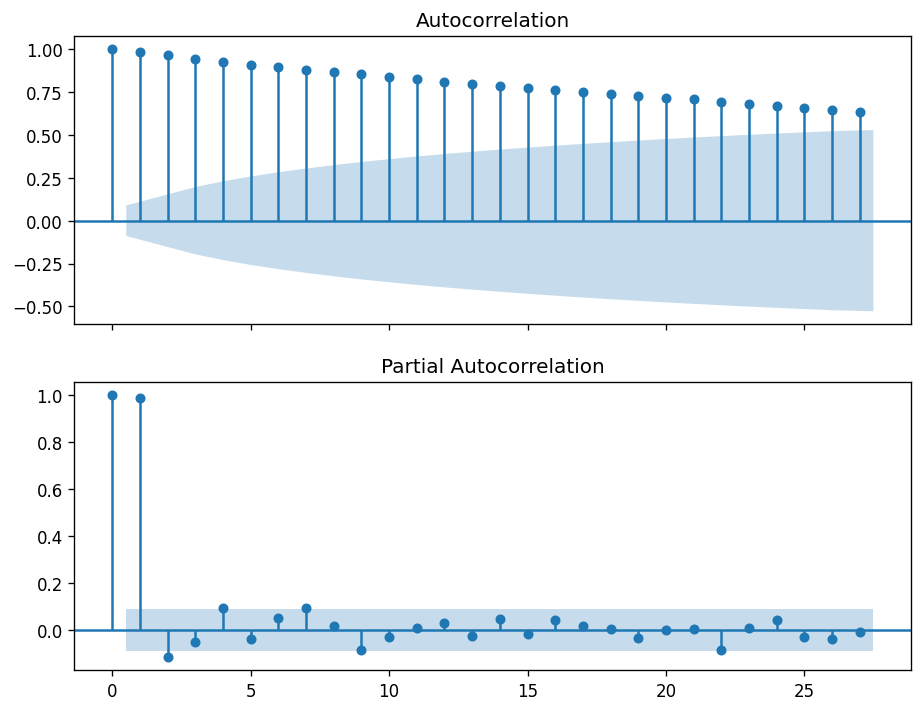

In [8]:
## 放大畫圖觀察PACF跟ACF來決定我們的 p,q超參數
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
fig, axes = plt.subplots(2, 1, sharex=True)

## 1st differencing
axes[0].set_title('ACF')
plot_acf(data, ax=axes[0])
#

## 2nd differencing
axes[1].set_title('PACF')
plot_pacf(data, ax=axes[1])

plt.show()

In [10]:
## 幫我們直接算出最好的d
d = ndiffs(data)

### ADF test

In [11]:
## 用ADF檢定來看看原始資料是否存在單根
# The p-value > 0.05 accept Ho:the diff(1) exists
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)
print('p-value: {}'.format(round(result[1],4)))

p-value: 0.3723


In [12]:
## 用ADF檢定來看看差分後資料是否存在單根
# The p-value < 0.05 reject Ho:the diff(1) exists
from statsmodels.tsa.stattools import adfuller
result = adfuller(train.diff(1).dropna())
print('p-value: {}'.format(round(result[1],4)))

p-value: 0.0


In [13]:
path = "WeeklyFinalData.csv"
data = read(path)
train = data["CCSP"][:-92]
test = data["CCSP"][-92:]

### Dynamic prediction with ARIMA

In [16]:
predictions = list()

for t in range(test.shape[0]):
    model = ARIMA(train, order=(1, 1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0].tolist()
    predictions.extend(yhat)
    train = np.append(train,yhat)
    train = np.delete(train, t)

### Use "auto_arima()" to setup the ARIMA model
    perform a "random search" over a hyper-parameter space

In [17]:
model = pm.auto_arima(train, start_p=2, start_q=1,
                      information_criterion='aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6305.504, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6311.364, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6313.345, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6313.085, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6309.759, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6317.727, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6312.456, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6300.194, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6298.464, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=6296.795, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6310.925, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=6298.503, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6318.591, Time=0.04 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 1.059 seconds
                      

In [18]:
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=53,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[53]             : AIC=5658.643, Time=36.67 sec
 ARIMA(0,1,0)(0,1,0)[53]             : AIC=5730.416, Time=1.29 sec


KeyboardInterrupt: 

### Model the SARIMA model

In [19]:
model = sm.tsa.statespace.SARIMAX(train, order=(1,1,0), seasonal_order=(0,1,2,53))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  387
Model:             SARIMAX(1, 1, 0)x(0, 1, [1, 2], 53)   Log Likelihood               -2827.407
Date:                                 Sat, 12 Jun 2021   AIC                           5662.813
Time:                                         04:41:51   BIC                           5678.046
Sample:                                              0   HQIC                          5668.887
                                                 - 387                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0556      0.017      3.200      0.001       0.022       0.090
ma.S.L53      -0.3305      0.016    -21.315      0.000      -0.361      -0.300
ma.S.L106     -0.0710      0.013     -5.328      0.000      -0.097      -0.045
sigma2      1.572e+06   9.03e+04     17.397      0.000    1.39e+06    1.75e+06
===================================================================================
Ljung-Box (L1) (Q):                  10.41   Jarque-Bera (JB):               315.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Forecast

In [20]:
pre = model_fit.forecast(92)

In [21]:
performance["SARIMA"]=pre

# 2. Modeling for GARCH

# Read and pre-process data

In [41]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Flatten, Input
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Metric

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
tf.compat.v1.keras.backend.set_session(sess)

In [42]:
def buildTrain(train, pastWeek=21, futureWeek=1, defaultWeek=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureWeek-pastWeek):
       
        X = np.array(train.iloc[i:i+defaultWeek])
        X = np.append(X,train["CCSP"].iloc[i+defaultWeek:i+pastWeek])
        
        X_train.append(X.reshape(X.size))
        Y_train.append(np.array(train.iloc[i+pastWeek:i+pastWeek+futureWeek]["CCSP"]))
    
    return np.array(X_train), np.array(Y_train)

In [43]:
def get_data():
    
    ## Read weekly copper price data
    path = "WeeklyFinalData.csv"
    data = read(path)
    
    date = data["Date"]
    data.drop("Date", axis=1, inplace=True)
    
    ## Add time lag (pastWeek=4, futureWeek=1)
    x_data, y_data = buildTrain(data)
    
    ## Data split
    x_train = x_data[0:int(x_data.shape[0]*0.8)]
    x_test = x_data[int(x_data.shape[0]*0.8):]
    
    y_train = y_data[0:int(y_data.shape[0]*0.8)]
    y_test = y_data[int(y_data.shape[0]*0.8):]
    
    return (x_train, x_test, y_train, y_test)

In [44]:
sc = MinMaxScaler(feature_range = (0, 1))

In [45]:
x_train, x_test, y_train, y_test = get_data()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)
y_train_scaled = sc.fit_transform(y_train)

# Modeling for SVR

In [46]:
from sklearn.svm import SVR

In [47]:
svr_rbf = SVR(kernel = 'rbf', C=1e3 , gamma = 0.1)
svr_rbf.fit(x_train_scaled, y_train_scaled)

SVR(C=1000.0, gamma=0.1)

In [48]:
SVR_predict = svr_rbf.predict(x_test_scaled).reshape(-1,1)
performance["SVR"] = sc.inverse_transform(SVR_predict)

# 3. Modeling for ANN

### Build 2-layer neural network

In [49]:
def buildTwoLayerNN(input_shape):

    keras.backend.clear_session()
    model = Sequential()
    model.add(Dense(units=11, activation ="relu", input_shape=(input_shape,)))
    model.add(Dense(units=1)) 

    model.compile(optimizer="Adam", loss="mean_squared_error")

    return model

In [50]:
input_shape = x_train_scaled.shape[1]
model = buildTwoLayerNN(input_shape)

In [51]:
model.fit(x_train_scaled, y_train_scaled, epochs=300, batch_size=14, verbose=0)

### Forecast

In [52]:
# model.save("ann_model_weight.h5")
ANN_predict = model.predict(x_test_scaled)
performance["ANN"] = sc.inverse_transform(ANN_predict).flatten()

# Prepare the corresponding data for RNN-based NN

In [53]:
def buildTrain(train, pastWeek, futureWeek=1, defaultWeek=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureWeek-pastWeek):
        
        X = np.array(train.iloc[i:i+pastWeek,:])
        
        X_train.append(X.reshape(X.size))
        Y_train.append(np.array(train.iloc[i+pastWeek:i+pastWeek+futureWeek]["CCSP"]))
    return (np.array(X_train), np.array(Y_train))

In [54]:
def get_data(timeLag):
    
    ## Read weekly copper price data
    path = "WeeklyFinalData.csv"
    data = read(path)
    
    date = data["Date"]
    data.drop("Date", axis=1, inplace=True)
    
    ## Add time lag (pastWeek=4, futureWeek=1)
    x_data, y_data = buildTrain(data, timeLag)
    
    ## Data split
    x_train = x_data[0:int(x_data.shape[0]*0.8)]
    x_test = x_data[int(x_data.shape[0]*0.8):]
    
    y_train = y_data[0:int(y_data.shape[0]*0.8)]
    y_test = y_data[int(y_data.shape[0]*0.8):]
    
    
    return (x_train, x_test, y_train, y_test)

In [55]:
x_train, x_test, y_train, y_test = get_data(21)
## The number of forecasting variable (# of variable)
nb_input_factor = 15

## Data transformation
x_train_scaled = sc.fit_transform(x_train).reshape(-1,21,nb_input_factor)
x_test_scaled = sc.transform(x_test).reshape(-1,21,nb_input_factor)
y_train_scaled = sc.fit_transform(y_train)

# 4. Modeling for RNN

In [83]:
import tensorflow as tf
from tensorflow import keras

In [84]:
from keras.layers import SimpleRNN

In [87]:
def buildRNN(shape):
    
    keras.backend.clear_session()
    model = keras.Sequential()
    model.add(SimpleRNN(28, input_shape=(shape[1], shape[2])))
    model.add(Dense(1))
    model.compile(optimizer="Adam", loss="mse")
#     model.summary()
    return model

In [88]:
model = buildRNN(x_train_scaled.shape)
model.fit(x_train_scaled, y_train_scaled, epochs=300, batch_size=14, verbose=0)
RNN_predict = model.predict(x_test_scaled)
performance["RNN"] = sc.inverse_transform(LSTM_predict).flatten()

# 5. Modeling for LSTM

In [89]:
from keras.layers import LSTM

In [90]:
def buildLSTM(shape):
    
    model = Sequential()
    model.add(LSTM(28, input_shape=(shape[1], shape[2])))
    model.add(Dense(1))
    model.compile(optimizer="Adam", loss="mse")
#     model.summary()
    return model

In [91]:
model = buildLSTM(x_train_scaled.shape)
model.fit(x_train_scaled, y_train_scaled, epochs=300, batch_size=14, verbose=0)
LSTM_predict = model.predict(x_test_scaled)
performance["LSTM"] = sc.inverse_transform(LSTM_predict).flatten()

# 6. Modeling for GRU

In [92]:
from keras.layers import GRU

In [93]:
def buildGRU(shape):
    
    model = Sequential()
    model.add(GRU(28, input_shape=(shape[1], shape[2])))
    model.add(Dense(1))
    model.compile(optimizer="Adam", loss="mse")
#     model.summary()
    return model

In [94]:
model = buildGRU(x_train_scaled.shape)
model.fit(x_train_scaled, y_train_scaled, epochs=300, batch_size=14, verbose=0)
GRU_predict = model.predict(x_test_scaled)
performance["GRU"] = sc.inverse_transform(GRU_predict).flatten()

# Plot a graph comparing the predicted value with the actual value.

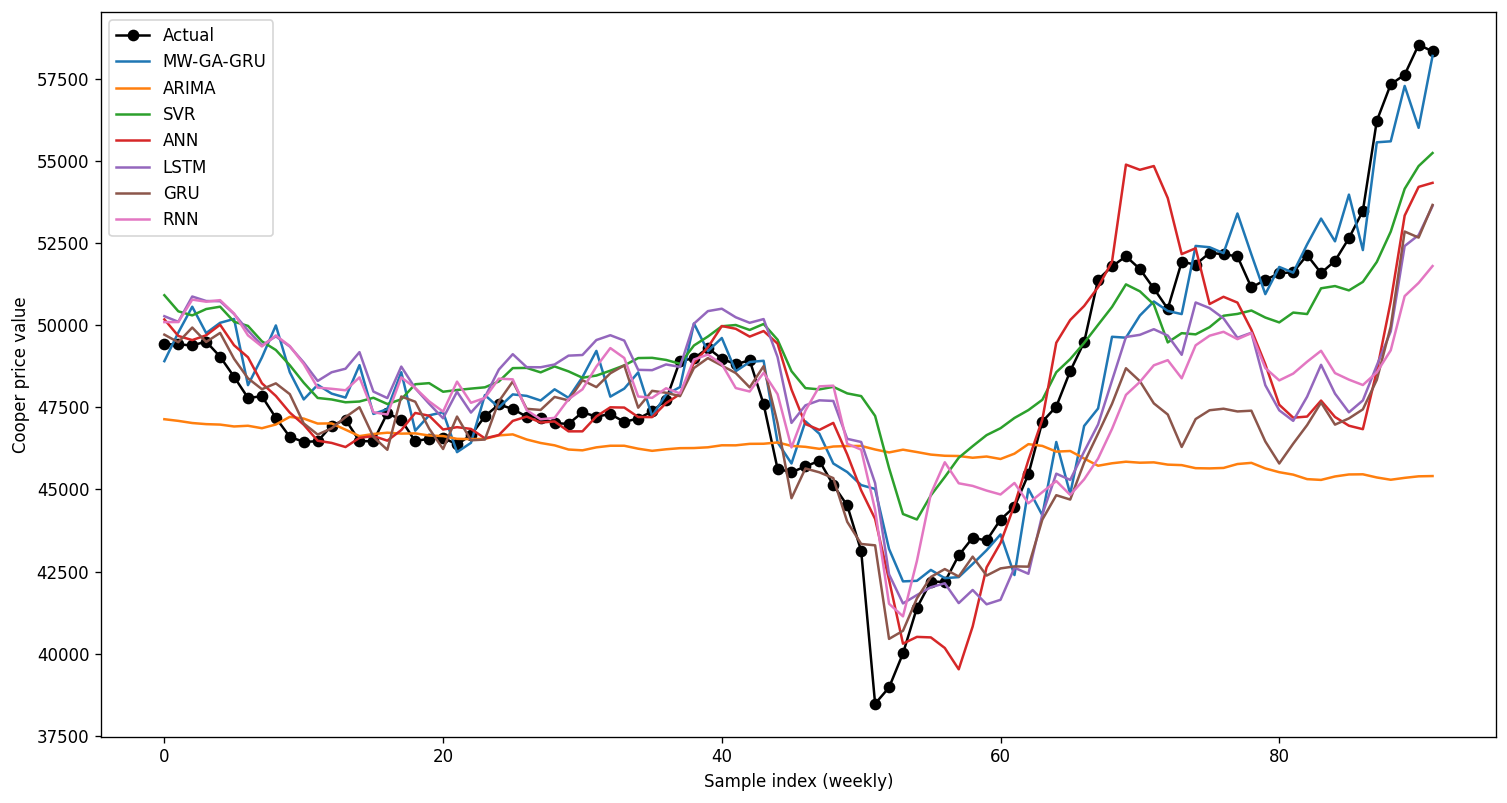

In [95]:
plt.figure(figsize=(15,8))

plt.plot(range(performance["Actual"].shape[0]), performance["Actual"], "-o",color='black', label = 'Actual')

for i in range(1,performance.shape[1]):
    t_data = performance.iloc[:,i]
    plt.plot(t_data, label=performance.columns[i])

plt.legend()
plt.xlabel("Sample index (weekly)")
plt.ylabel("Cooper price value")
plt.savefig('RMSE.png')

# Create the function to evaluate the performance of each model based on the RMSE, MAE, MAPE, and the accuracy from 500 to 3000 tolerance.

In [96]:
evaluation_results = pd.DataFrame(columns=["Model","MAE","MAPE","RMSE"])

mae = tf.keras.losses.MeanAbsoluteError()
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

for i in range(1,performance.shape[1]):
    
    val_mae = mae(performance["Actual"], performance.iloc[:,i]).numpy()
    val_mape = mape(performance["Actual"], performance.iloc[:,i]).numpy()
    val_rmse = tf.math.sqrt(mse(performance["Actual"], performance.iloc[:,i])).numpy()
    accuracy = list()
    
    for threshold in range(500,3001,500):
        
        y_true = performance["Actual"]
        y_pred = performance.iloc[:,i]
        
        total_times = y_true.shape[0]
        correct_times = 0
        
        for _ in range(total_times): 

            correct_times = np.count_nonzero(abs(y_true-y_pred) < threshold)
        
        accuracy.append(correct_times/total_times)

    
    new_result = pd.DataFrame({

        "Model" : [performance.columns[i]],
        "MAE" : [val_mae],
        "MAPE" : [val_mape],
        "RMSE" : [val_rmse],
        "Accuracy(500)" : accuracy[0],
        "Accuracy(1000)" : accuracy[1],
        "Accuracy(1500)" : accuracy[2],
        "Accuracy(2000)" : accuracy[3],
        "Accuracy(2500)" : accuracy[4],
        "Accuracy(3000)" : accuracy[5]
        
    })

    evaluation_results = evaluation_results.append(new_result, ignore_index=True)
evaluation_results

Model          MAE      MAPE         RMSE  Accuracy(500)  \
0  MW-GA-GRU  1088.425049  2.315730  1515.365880       0.326087   
1      ARIMA  3229.401611  6.470435  4527.191845       0.130435   
2        SVR  1874.975098  4.005716  2313.280031       0.086957   
3        ANN  1587.779053  3.218047  2369.448975       0.336957   
4       LSTM  2296.654785  4.697447  2758.138672       0.054348   
5        GRU  1974.753418  3.910425  2849.153320       0.304348   
6        RNN  2183.991943  4.431569  2806.131592       0.097826   

   Accuracy(1000)  Accuracy(1500)  Accuracy(2000)  Accuracy(2500)  \
0        0.565217        0.771739        0.847826        0.913043   
1        0.369565        0.423913        0.478261        0.554348   
2        0.239130        0.478261        0.663043        0.771739   
3        0.565217        0.652174        0.728261        0.750000   
4        0.119565        0.282609        0.554348        0.695652   
5        0.510870        0.641304        0.663043        0.663043   
6        0.315217        0.402174        0.565217        0.684783   

   Accuracy(3000)  
0        0.956522  
1        0.619565  
2        0.847826  
3        0.793478  
4        0.771739  
5        0.695652  
6        0.760870

In [97]:
performance.to_csv("result.csv", index=False)